<a href="https://colab.research.google.com/github/kkostromin/sber_ds/blob/main/ew_kostromink_age_gender_colab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm import tqdm

import tensorflow as tf

import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torch.nn.functional as func 
from torch.utils.data import Dataset

from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from torchvision import transforms


In [78]:

import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
# torch imports
import torch
from torch import nn

from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn.functional as F


# Download data in kaggle input

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# # for dirname, _, filenames in os.walk('/kaggle/input'):
# #     for filename in filenames:
# #         print(os.path.join(dirname, filename))

# for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/Datesciense/sber/dataset/crop_part1'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# install utils

In [3]:
!pip install ipython-autotime

%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.4 MB/s 
time: 402 µs (started: 2022-12-21 10:29:44 +00:00)


## check GPU

In [ ]:
# # check if CUDA is available
# train_on_gpu = torch.cuda.is_available()

# if not train_on_gpu:
#     print('CUDA is not available.  Training on CPU ...')
# else:
#     print('CUDA is available!  Training on GPU ...')
    
# device_num = 0
# device = f"cuda:{device_num}" if torch.cuda.is_available() else "cpu"

# print(f"Device: {device}")

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17178940693253489668
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6244221031655435587
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
from tensorflow import python as tf_python
tf.python.client.device_lib.list_local_devices()

AttributeError: ignored

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Описание датасета

Aligned&Cropped Faces

Labels
The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age
[gender] is either 0 (male) or 1 (female)
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

# 1.Load Data

# 1.1 Dowlload BigDataframe 
csv
https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv

23705 rows × 6 columns

In [28]:
! git clone https://github.com/ArminBaz/UTK-Face

Cloning into 'UTK-Face'...
remote: Enumerating objects: 140, done.
remote: Total 140 (delta 0), reused 0 (delta 0), pack-reused 140
Receiving objects: 100% (140/140), 100.34 MiB | 50.39 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [29]:
dataFrame = pd.read_csv('UTK-Face/data/age_gender.gz', compression='gzip')

In [30]:
dataFrame

,Unnamed: 0,age,ethnicity,gender,img_name,pixels
0,0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...,...
23700,23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


# 1.2 Dowlload Small Dataset 

crop_part1


In [6]:
path = "/content/gdrive/MyDrive/Datesciense/sber/dataset/"

In [7]:
import os
import tarfile
arch = tarfile.open(os.path.join(path,'crop_part1.tar.gz'), 'r')
arch.getnames()[:3]

['crop_part1/24_1_2_20170104020224692.jpg.chip.jpg',
 'crop_part1/3_1_3_20161219230106056.jpg.chip.jpg',
 'crop_part1/35_0_0_20170105162448427.jpg.chip.jpg']

In [31]:
file_names = []
for name in arch.getnames():
    name = name.replace('crop_part1/', '')
    name = name.replace('.chip.jpg', '')
    file_names.append(name)
file_names[:3]

['24_1_2_20170104020224692.jpg',
 '3_1_3_20161219230106056.jpg',
 '35_0_0_20170105162448427.jpg']

In [9]:
len(file_names)

9781

In [21]:
file_names.remove('crop_part1')

In [27]:
#  exapmle name of file in dataset  /kaggle/input/utkface-new/crop_part1/65_1_0_20170110182002744.jpg.chip.jpg

# path = "/content/gdrive/MyDrive/Datesciense/sber/dataset/crop_part1/"

images = []
ages = []
genders = []
race = []

for i in file_names:
    # print(i)
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    if len(split[2]) == 1:
        race.append(int(split[2]))
    else: 
        race.append("nan")
    # images.append(Image.open(path + i))
    images.append(i)

всего файлов в датасете crop_part1.

In [6]:
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 9780
3_1_0_20170109191958848.jpg.chip.jpg
time: 170 ms (started: 2022-12-21 10:33:43 +00:00)


In [32]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')
race = pd.Series(list(race), name = 'Race')

df = pd.concat([images, ages, genders, race], axis=1)
df

,Images,Ages,Genders,Race
0,24_1_2_20170104020224692.jpg,24,1,2
1,3_1_3_20161219230106056.jpg,3,1,3
2,35_0_0_20170105162448427.jpg,35,0,0
3,5_0_0_20170110213554657.jpg,5,0,0
4,23_1_4_20170103223615095.jpg,23,1,4
...,...,...,...,...
9775,49_0_0_20170104205813820.jpg,49,0,0
9776,25_0_0_20170104004136182.jpg,25,0,0
9777,1_0_2_20161219211357821.jpg,1,0,2
9778,6_1_0_20170109202302115.jpg,6,1,0


In [33]:
df.shape


(9780, 4)

# 1.3 Data prepare (nan)

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9780 entries, 0 to 9779
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Images   9780 non-null   object
 1   Ages     9780 non-null   int64 
 2   Genders  9780 non-null   int64 
 3   Race     9780 non-null   object
dtypes: int64(2), object(2)
memory usage: 305.8+ KB
time: 13.1 ms (started: 2022-12-21 11:41:30 +00:00)


In [34]:
Ages_mass = np.sort(df['Ages'].unique())
print(Ages_mass)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  95  96  99 100 101 110]


In [35]:
Ages_counts = df["Ages"].value_counts(normalize=False)
Ages_counts

1      1112
2       475
3       284
26      279
4       260
       ... 
110       2
99        2
100       2
101       1
91        1
Name: Ages, Length: 99, dtype: int64

In [47]:
# labels = Ages_mass
# df.groupby(['Ages']).sum().plot(kind='pie', y=Ages_mass[1])


In [37]:
df['Genders'].unique()

array([1, 0, 3])

In [38]:
gender_counts = df["Genders"].value_counts(normalize=False)
print(gender_counts)

1    5407
0    4372
3       1
Name: Genders, dtype: int64


In [39]:
df['Race'].unique()

array([2, 3, 0, 4, 1, 'nan'], dtype=object)

In [40]:
race_counts = df["Race"].value_counts(normalize=False)
print(race_counts)

0      5265
2      1553
3      1452
4      1103
1       405
nan       2
Name: Race, dtype: int64


In [41]:
df['Race'] = df['Race'].astype('string')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9780 entries, 0 to 9779
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Images   9780 non-null   object
 1   Ages     9780 non-null   int64 
 2   Genders  9780 non-null   int64 
 3   Race     9780 non-null   string
dtypes: int64(2), object(1), string(1)
memory usage: 305.8+ KB
None


In [42]:
df = df[df['Race'].str.contains('nan') == False]

In [43]:
df['Race'].unique()

<StringArray>
['2', '3', '0', '4', '1']
Length: 5, dtype: string

In [45]:
df['Race'] = df['Race'].astype('int64')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9778 entries, 0 to 9779
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Images   9778 non-null   object
 1   Ages     9778 non-null   int64 
 2   Genders  9778 non-null   int64 
 3   Race     9778 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 382.0+ KB
None


<ipython-input-45-321fa5b5ed0d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Race'] = df['Race'].astype('int64')


In [46]:
df

,Images,Ages,Genders,Race
0,24_1_2_20170104020224692.jpg,24,1,2
1,3_1_3_20161219230106056.jpg,3,1,3
2,35_0_0_20170105162448427.jpg,35,0,0
3,5_0_0_20170110213554657.jpg,5,0,0
4,23_1_4_20170103223615095.jpg,23,1,4
...,...,...,...,...
9775,49_0_0_20170104205813820.jpg,49,0,0
9776,25_0_0_20170104004136182.jpg,25,0,0
9777,1_0_2_20161219211357821.jpg,1,0,2
9778,6_1_0_20170109202302115.jpg,6,1,0


# 2. Show example pic

In [ ]:
def draw_image_from_dataset(filenumber):    
    display(df['Images'][filenumber])
    print('ages - ' + str(df['Ages'][filenumber]),' ---  gender - ' + str(df['Genders'][filenumber]))
    print()

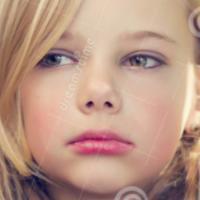

ages - 10  ---  gender - 1



In [ ]:
draw_image_from_dataset(155)

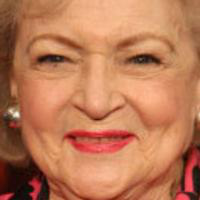

ages - 88  ---  gender - 1



In [ ]:
draw_image_from_dataset(3888)

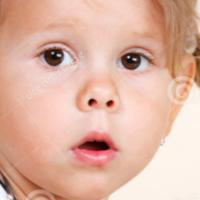

ages - 3  ---  gender - 1



In [ ]:
draw_image_from_dataset(3)

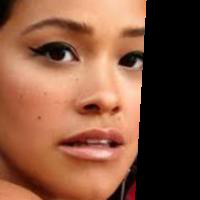

ages - 20  ---  gender - 1



In [ ]:
draw_image_from_dataset(6005)

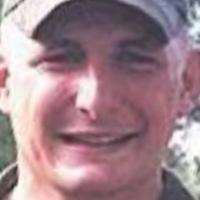

ages - 28  ---  gender - 0



In [ ]:
draw_image_from_dataset(7005)

**Таким образом, 0 соответствует мужчине, 1 соответствует женщине.**

# 3. Visualisation

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


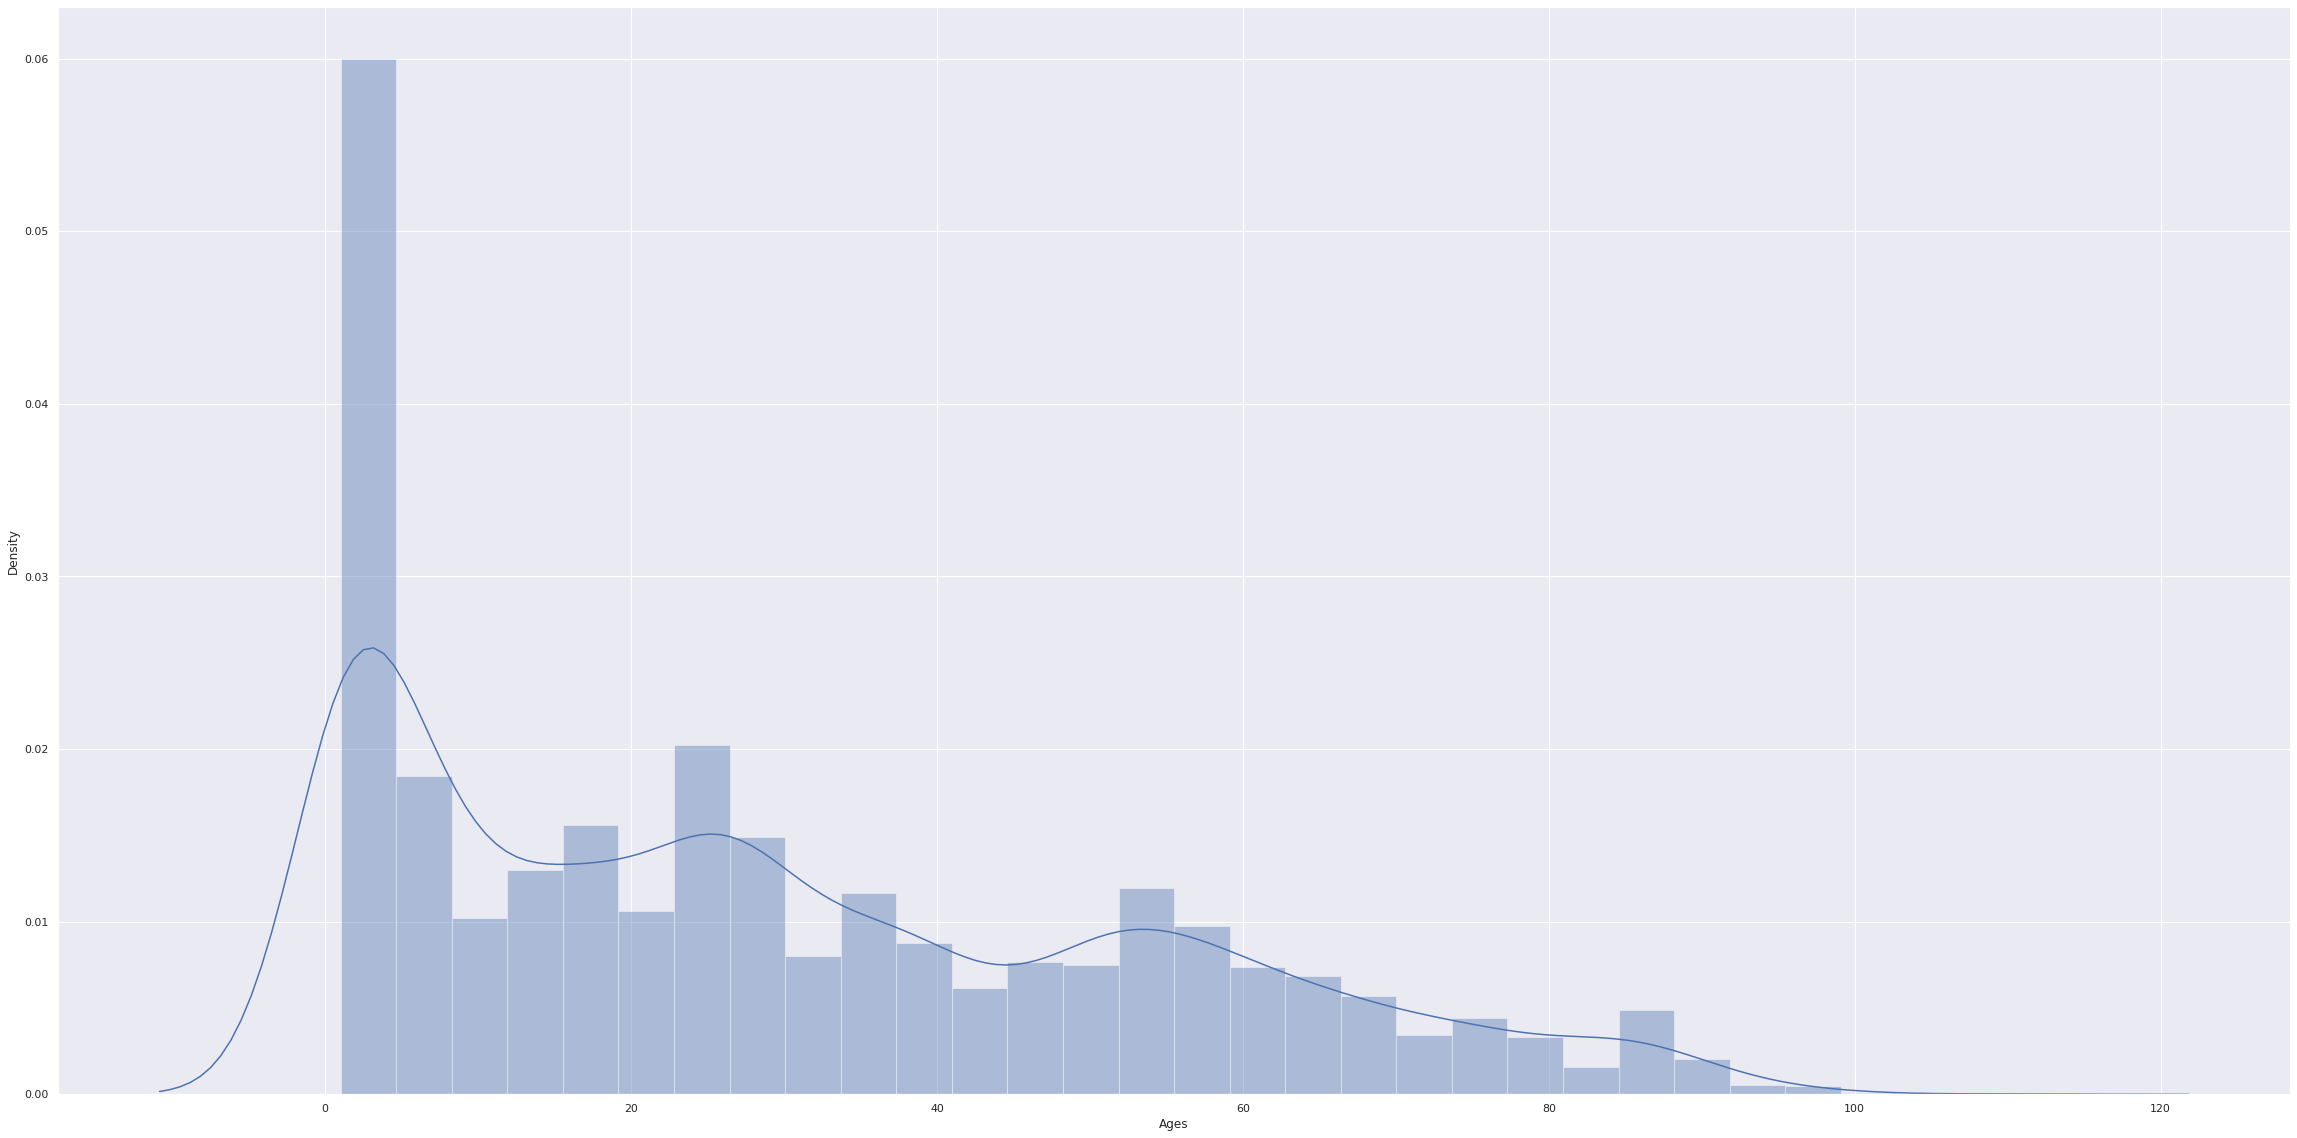

In [49]:
plt.rcParams["figure.figsize"] = (40,20)
sns.set_theme()
sns.distplot(df['Ages'],kde=True, bins=30)

Too many faces of people between 0 and 4 years old. The model would fit too well to these ages and not enough to the other ages. To resolve this I'm only going to include a third of the images between these ages.

In [50]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


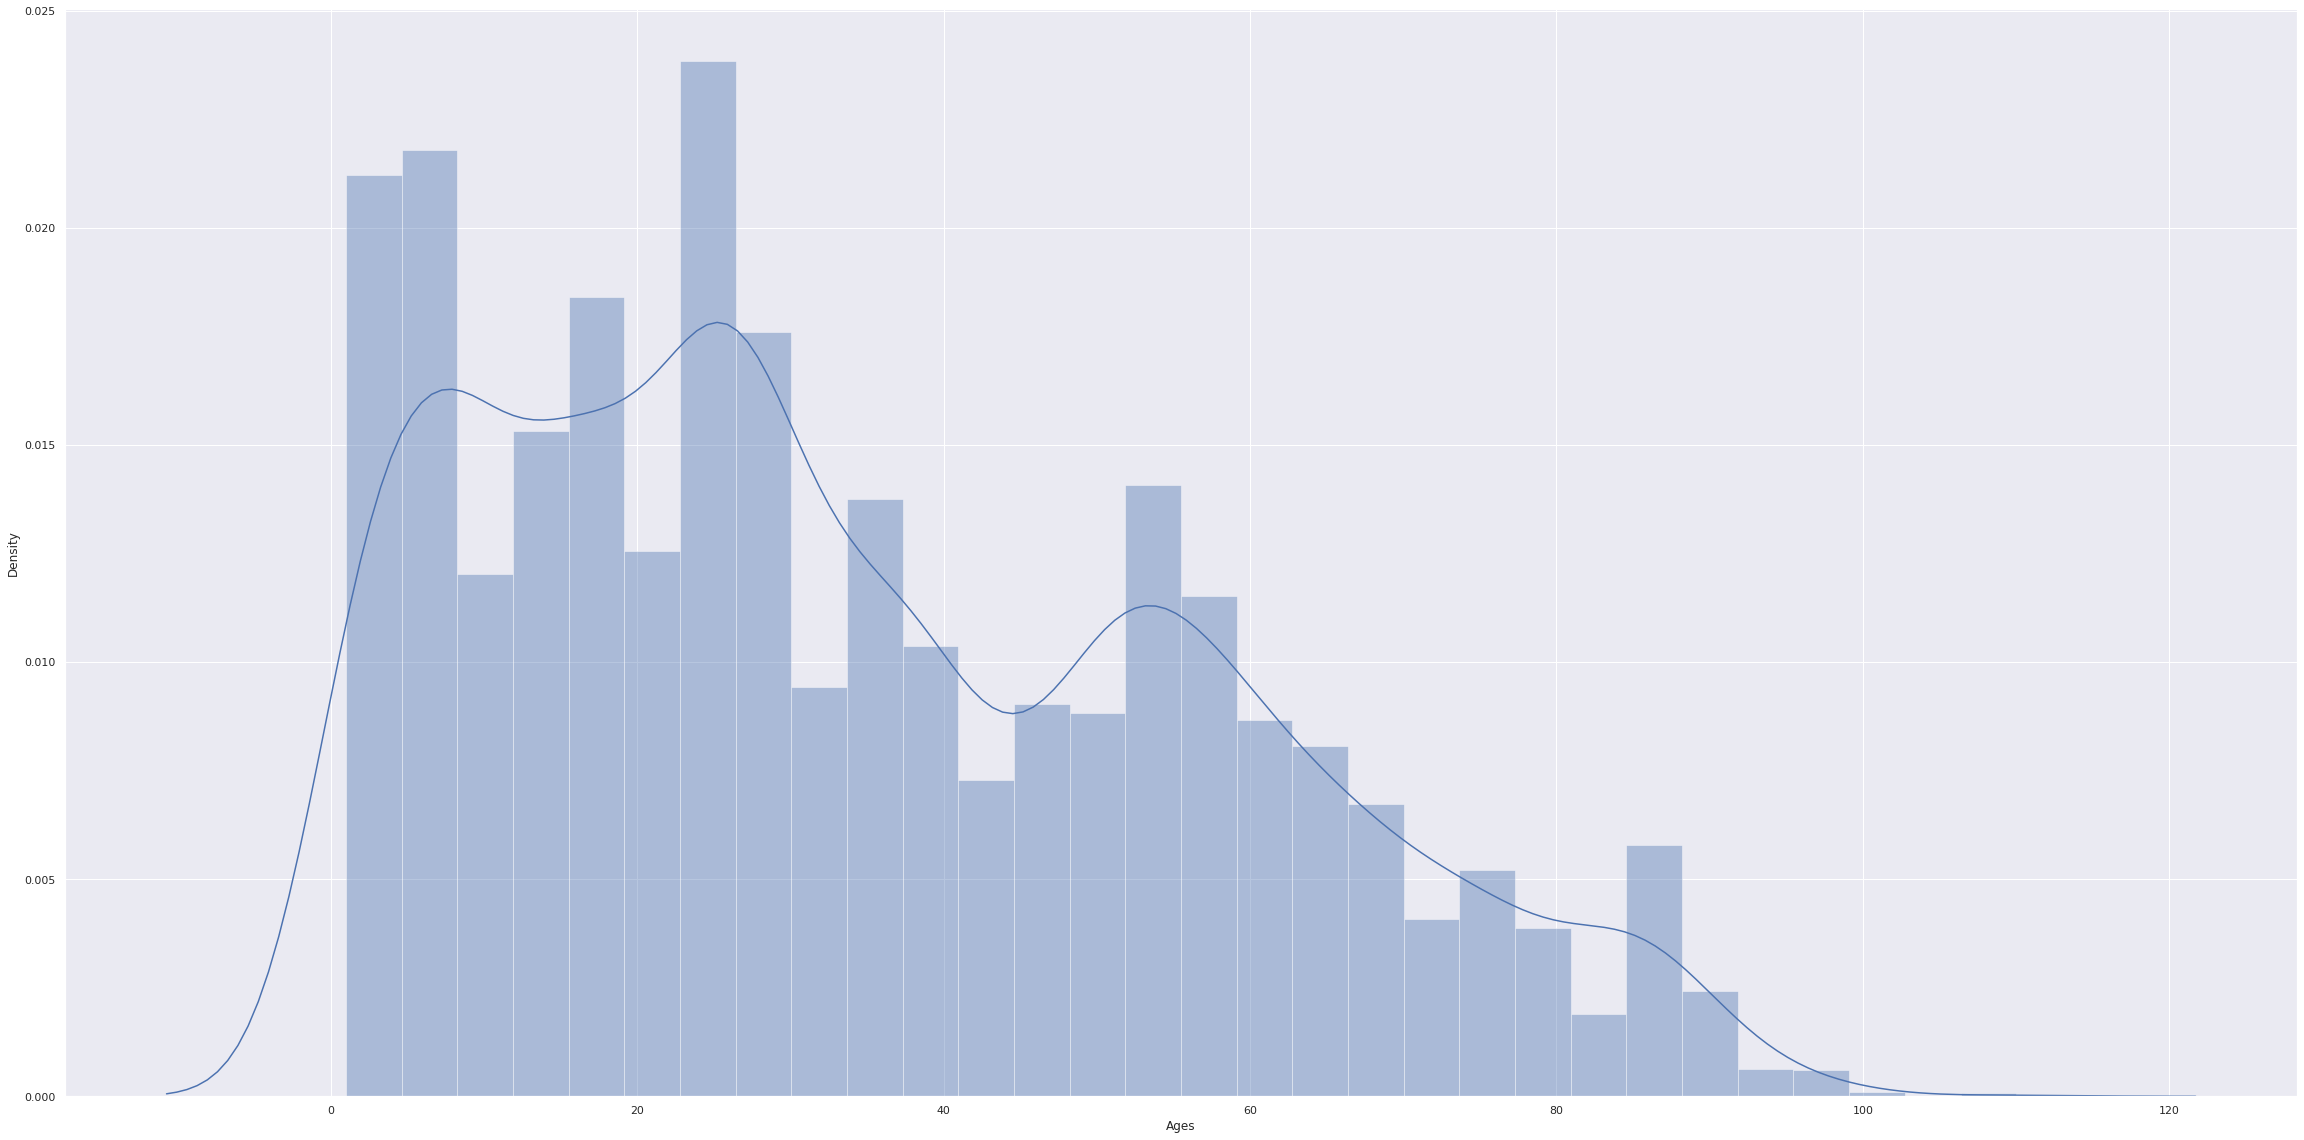

In [51]:
sns.distplot(df['Ages'],kde=True, bins=30)

This looks much better! The dataframe is more representative of the population now. However, there aren't many images of people over 80, which would cause the model to not train well enough on those ages. It's best to just remove over 80s and only have a model that can predict the ages of people under 80.

In [52]:
df = df[df['Ages'] < 80]

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


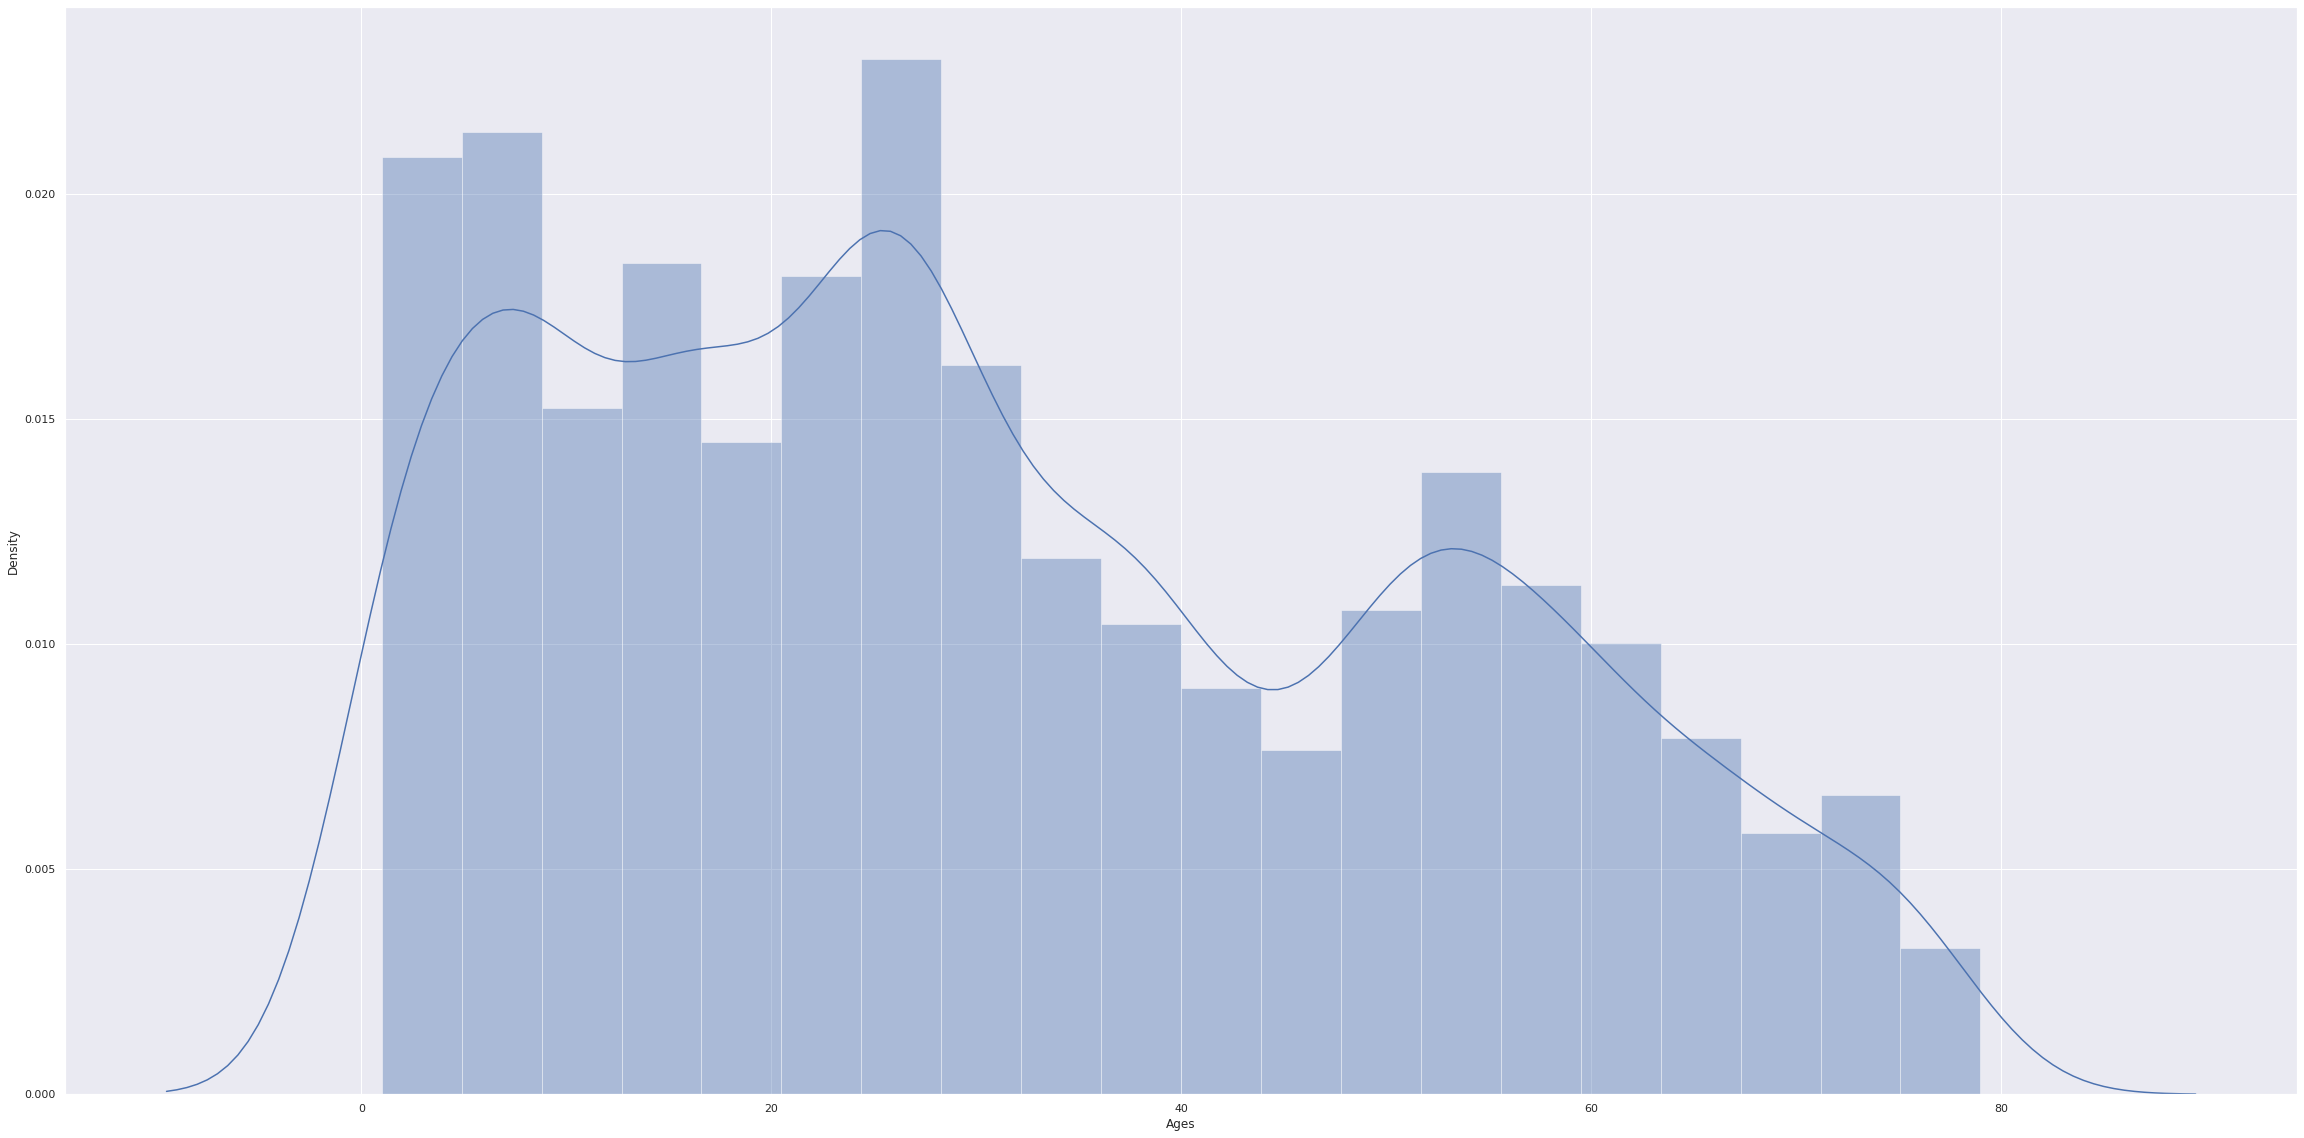

In [53]:
sns.distplot(df['Ages'],kde=True, bins=20)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


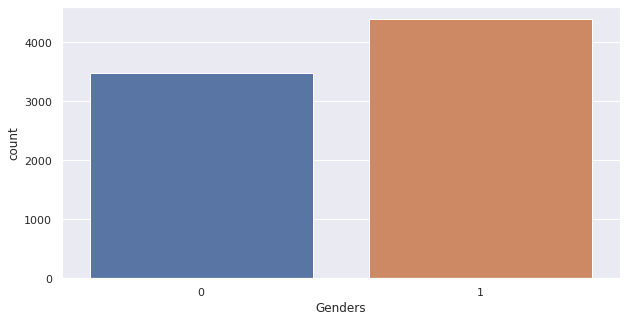

In [54]:
plt.rcParams["figure.figsize"] = (10,5)
sns.countplot(df['Genders'])

Not sure what 3 corresponds to - both genders, no gender, unknown, or just an error in the data entry? To be safe, I am going to remove any rows where gender equals 3.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


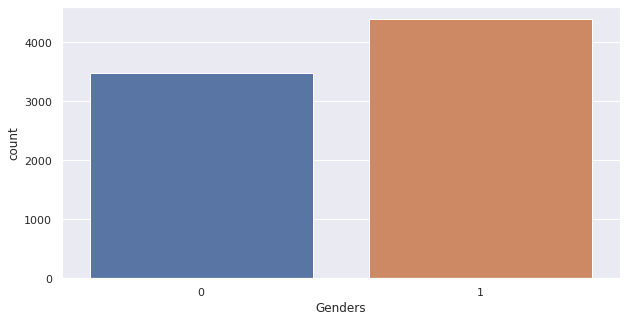

In [55]:
df = df[df['Genders'] != 3]
sns.countplot(df['Genders'])

# 4. Data loader 

In [56]:
df2 = df.copy()

In [57]:
df2

,Images,Ages,Genders,Race
0,24_1_2_20170104020224692.jpg,24,1,2
1,35_0_0_20170105162448427.jpg,35,0,0
2,5_0_0_20170110213554657.jpg,5,0,0
3,23_1_4_20170103223615095.jpg,23,1,4
4,20_1_3_20170104231456714.jpg,20,1,3
...,...,...,...,...
8281,2_0_0_20170110212852343.jpg,2,0,0
8282,4_1_3_20161219230310713.jpg,4,1,3
8283,1_0_2_20161219162431598.jpg,1,0,2
8284,1_1_3_20161220222647563.jpg,1,1,3


In [58]:
# Construct age bins
age_bins = [0, 10, 15, 20 ,25 ,30 ,40 ,50 ,60 ,80]
age_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
df2['bins'] = pd.cut(df2.Ages, bins=age_bins, labels=age_labels)


In [59]:
# Example
df2[df2['Ages'] == 14]

,Images,Ages,Genders,Race,bins
45,14_1_0_20170109203842960.jpg,14,1,0,1
89,14_1_0_20170109204135732.jpg,14,1,0,1
104,14_1_0_20170109214635943.jpg,14,1,0,1
137,14_0_2_20170110232701995.jpg,14,0,2,1
143,14_0_0_20170110232801598.jpg,14,0,0,1
...,...,...,...,...,...
7335,14_1_0_20170104011733528.jpg,14,1,0,1
7338,14_1_0_20170103200702463.jpg,14,1,0,1
7397,14_1_0_20170109204131257.jpg,14,1,0,1
7447,14_1_0_20170109212749213.jpg,14,1,0,1


# Func UTKDataset

In [120]:
class UTKDataset(Dataset):
    ''' 
     https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
        Inputs:
            dataFrame : Pandas dataFrame
            transform : The transform to apply to the dataset
    '''
    def __init__(self, df2, transform=None):
        # read in the transforms
        self.transform = transform
        
        # # Use the dataFrame to get the pixel values
        # data_holder = dataFrame.pixels.apply(lambda x: np.array(x.split(" "),dtype=float))
        # arr = np.stack(data_holder)
        # arr = arr / 255.0
        # arr = arr.astype('float32')
        # arr = arr.reshape(arr.shape[0], 48, 48, 1)
        # # reshape into 48x48x1
        # self.data = arr
        
        # get the age, gender, and ethnicity label arrays
        self.age_label = np.array(df2.bins[:])        # Note : Changed df2.age to df2.bins with most recent change
        self.gender_label = np.array(df2.Genders[:])
        self.eth_label = np.array(df2.Race[:])
    
    # override the length function
    def __len__(self):
         return len(self.age_label)
    
    # override the getitem function
    def __getitem__(self, index):
        # load the data at index and apply transform
        # data = self.data[index]
        # data = self.transform(data)
        
        # load the labels into a list and convert to tensors
        labels = torch.tensor((self.age_label[index], self.gender_label[index], self.eth_label[index]))
        
        # return data labels
        return labels

# 5.Data transform

In [129]:
dataFrame

,Unnamed: 0,age,ethnicity,gender,img_name,pixels,bins
0,0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...,0
1,1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...,0
2,2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,0
3,3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...,0
4,4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...,0
...,...,...,...,...,...,...,...
23700,23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...,NaN
23701,23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...,NaN
23702,23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...,NaN
23703,23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...,NaN


In [128]:
dataFrame['pixels'][0]

'129 128 128 126 127 130 133 135 139 142 145 149 147 145 146 147 148 149 149 150 153 153 153 152 153 153 153 153 153 151 149 147 146 146 144 143 140 134 129 129 126 122 121 119 118 118 99 53 130 129 128 126 127 130 135 141 143 143 144 145 143 142 144 145 146 149 149 148 151 151 151 151 152 153 153 153 153 149 148 147 146 146 142 141 138 133 130 130 128 123 124 122 120 117 98 52 131 129 130 129 129 134 138 144 145 143 143 139 140 138 139 140 142 145 147 149 151 149 149 149 151 152 151 150 150 148 147 145 144 142 140 137 136 135 134 131 128 126 126 123 122 114 97 50 135 134 133 132 131 136 142 145 147 144 141 143 138 131 133 134 137 139 143 147 148 149 149 149 151 151 149 147 147 146 141 139 135 137 137 137 137 138 137 134 132 129 130 124 124 115 95 52 138 139 139 135 134 138 140 140 140 140 140 140 139 134 131 127 131 131 133 138 143 148 149 149 150 151 148 144 141 138 139 133 133 137 139 139 141 140 140 136 132 131 132 125 125 115 91 50 141 145 144 138 135 139 139 133 127 123 124 122 1

In [97]:
df2

,Images,Ages,Genders,Race,bins
0,24_1_2_20170104020224692.jpg,24,1,2,3
1,35_0_0_20170105162448427.jpg,35,0,0,5
2,5_0_0_20170110213554657.jpg,5,0,0,0
3,23_1_4_20170103223615095.jpg,23,1,4,3
4,20_1_3_20170104231456714.jpg,20,1,3,2
...,...,...,...,...,...
8281,2_0_0_20170110212852343.jpg,2,0,0,0
8282,4_1_3_20161219230310713.jpg,4,1,3,0
8283,1_0_2_20161219162431598.jpg,1,0,2,0
8284,1_1_3_20161220222647563.jpg,1,1,3,0


In [125]:
# Construct age bins
age_bins = [0,10,15,20,25,30,40,50,60,80]
age_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
df2['bins'] = pd.cut(df2.Ages, bins=age_bins, labels=age_labels)

# Split into training and testing
train_dataFrame, test_dataFrame = train_test_split(df2, test_size=0.2)

# get the number of unique classes for each group
class_nums = {'age_num':len(df2['bins'].unique()), 'eth_num':len(df2['Race'].unique()),
              'gen_num':len(df2['Genders'].unique())}

# Define train and test transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49,), (0.23,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49,), (0.23,))
])

# Construct the custom pytorch datasets
train_set = UTKDataset(train_dataFrame, transform=train_transform)
test_set = UTKDataset(test_dataFrame, transform=test_transform)

# Load the datasets into dataloaders
train_batch_gen = DataLoader(train_set, batch_size=64, shuffle=True)
test_batch_gen = DataLoader(test_set, batch_size=128, shuffle=False)

# print(train_batch_gen)
# Sanity Check
for X, y in train_batch_gen:
    print(f'Shape of training X: {X.shape}')
    print(f'Shape of y: {y.shape}')
    break

# return train_loader, test_loader, class_nums



Shape of training X: torch.Size([64, 3])
Shape of y: torch.Size([64, 3])


# 6. Model 

In [68]:
# High level feature extractor network (Adopted VGG type structure)
class highLevelNN(nn.Module):
    def __init__(self):
        super(highLevelNN, self).__init__()
        self.CNN = nn.Sequential(
            # first batch (32)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # second batch (64)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # Third Batch (128)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        out = self.CNN(x)

        return out

# Low level feature extraction module
class lowLevelNN(nn.Module):
    def __init__(self, num_out):
        super(lowLevelNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=2048, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=num_out)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=2, padding=1))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=3, stride=2, padding=1))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x


class TridentNN(nn.Module):
    def __init__(self, num_age, num_gen, num_eth):
        super(TridentNN, self).__init__()
        # Construct the high level neural network
        self.CNN = highLevelNN()
        # Construct the low level neural networks
        self.ageNN = lowLevelNN(num_out=num_age)
        self.genNN = lowLevelNN(num_out=num_gen)
        self.ethNN = lowLevelNN(num_out=num_eth)

    def forward(self, x):
        x = self.CNN(x)
        age = self.ageNN(x)
        gen = self.genNN(x)
        eth = self.ethNN(x)

        return age, gen, eth

# 6. Configure device


In [71]:
# Configure the device 
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

# Define the list of hyperparameters
hyperparameters = {'learning_rate':0.001, 'epochs':30}

# Initialize the TridentNN model and put on device
model = TridentNN(class_nums['age_num'], class_nums['gen_num'], class_nums['eth_num'])
model.to(device)

cpu


TridentNN(
  (CNN): highLevelNN(
    (CNN): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): ReLU()
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (9): ReLU()
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (14): ReLU()
    )
  )
  (ageNN): lowLevelNN(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

# func for load and save model

In [81]:

'''
  Functions to load and save a PyTorch model
'''
def save_checkpoint(state, epoch):
  print("Saving Checkpoint")
  filename = "tridentNN_epoch"+str(epoch)+".pth.tar"
  torch.save(state,filename)

def load_checkpoint(checkpoint):
  print("Loading Checkpoint")
  model.load_state_dict(checkpoint['state_dict'])
  opt.load_state_dict(checkpoint['optimizer'])

# 6. Train model

In [92]:
'''
train the model
''' 
# Load hyperparameters
learning_rate = hyperparameters['learning_rate']
num_epoch = hyperparameters['epochs']

# Define loss functions
age_loss = nn.CrossEntropyLoss()
gen_loss = nn.CrossEntropyLoss() # TODO : Explore using Binary Cross Entropy Loss?
eth_loss = nn.CrossEntropyLoss()

# Define optimizer
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epoch):
  # Construct tqdm loop to keep track of training
  loop = tqdm(enumerate(train_batch_gen), total=len(train_batch_gen), position=0, leave=True)
  age_correct, gen_correct, eth_correct, total = 0,0,0,0

  # save the model every 10 epochs
  if epoch % 10 == 0:
    checkpoint = {'state_dict' : model.state_dict(), 'optimizer' : opt.state_dict(), 
                  'age_loss' : age_loss, 'gen_loss' : gen_loss, 'eth_loss' : eth_loss}
    save_checkpoint(checkpoint, epoch)

  # Loop through dataLoader
  for _, (X,y) in loop:
    # Unpack y to get true age, eth, and gen values
    # Have to do some special changes to age label to make it compatible with NN output and Loss function
    #age, gen, eth = y[:,0].resize_(len(y[:,0]),1).float().to(device), y[:,1].to(device), y[:,2].to(device)
    
    age, gen, eth = y[:,0].to(device), y[:,1].to(device), y[:,2].to(device)
    # print(age)
    # print(gen)
    # print(eth)
    X = X.to(device)
    pred = model(X) # Forward pass
    print(pred)
    loss = age_loss(pred[0],age.long()) + gen_loss(pred[1],gen.long()) + eth_loss(pred[2],eth.long())   # Loss calculation

    # Backpropagation
    opt.zero_grad()          # Zero the gradient
    loss.backward()          # Calculate updates

    # Gradient Descent
    opt.step()               # Apply updates

    # Update num correct and total
    age_correct += (pred[0].argmax(1) == age).type(torch.float).sum().item()
    gen_correct += (pred[1].argmax(1) == gen).type(torch.float).sum().item()
    eth_correct += (pred[2].argmax(1) == eth).type(torch.float).sum().item()

    total += len(y)

    # Update progress bar
    loop.set_description(f"Epoch [{epoch+1}/{num_epoch}]")
    loop.set_postfix(loss = loss.item())

  # Update epoch accuracy
  gen_acc, eth_acc, age_acc = gen_correct/total, eth_correct/total, age_correct/total

  # print out accuracy and loss for epoch
  print(f'Epoch : {epoch+1}/{num_epoch},    Age Accuracy : {age_acc*100},    Gender Accuracy : {gen_acc*100},    Ethnicity Accuracy : {eth_acc*100}\n')

  0%|          | 0/297 [00:00<?, ?it/s]

Saving Checkpoint


  0%|          | 0/297 [00:00<?, ?it/s]

(tensor([[ 2.2947e-02, -4.9233e-02, -3.2921e-02,  1.2226e-01,  1.7302e-02,
         -1.1828e-01, -4.3327e-02, -1.0023e-01, -5.7036e-02, -5.1916e-04],
        [ 2.4003e-02, -4.7194e-02, -3.2268e-02,  1.2374e-01,  1.7491e-02,
         -1.1773e-01, -4.4946e-02, -9.9409e-02, -5.6085e-02, -4.1324e-03],
        [ 2.3188e-02, -4.8739e-02, -3.2823e-02,  1.2272e-01,  1.7419e-02,
         -1.1810e-01, -4.3709e-02, -9.9958e-02, -5.6759e-02, -1.2775e-03],
        [ 2.2827e-02, -4.9425e-02, -3.2949e-02,  1.2209e-01,  1.7290e-02,
         -1.1842e-01, -4.3099e-02, -1.0035e-01, -5.7031e-02, -2.4690e-04],
        [ 2.3494e-02, -4.8285e-02, -3.2617e-02,  1.2300e-01,  1.7456e-02,
         -1.1803e-01, -4.4189e-02, -9.9870e-02, -5.6548e-02, -2.1789e-03],
        [ 2.3311e-02, -4.8591e-02, -3.2767e-02,  1.2286e-01,  1.7413e-02,
         -1.1804e-01, -4.3854e-02, -9.9909e-02, -5.6725e-02, -1.5755e-03],
        [ 2.4026e-02, -4.7297e-02, -3.2325e-02,  1.2366e-01,  1.7502e-02,
         -1.1766e-01, -4.4994e-

IndexError: ignored

# func from CV_HOME  

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_dataset = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_dataset = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
# obtain training indices that will be used for validation
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx  

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_batch_gen = torch.utils.data.DataLoader(train_dataset , batch_size = batch_size,
    sampler=train_sampler, num_workers=num_workers)
val_batch_gen = torch.utils.data.DataLoader(train_dataset , batch_size = batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((200,200), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)
x = np.array(x)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# 4. Train Test Split

In [ ]:
y_age = df['Ages']
y_gender = df['Genders']
y_races = df['Race']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)
x_train_race, x_test_race, y_train_race, y_test_race = train_test_split(x, y_race, test_size=0.2, stratify=y_race)

# 5. Creating the Models

I will create two individual models - one to predict age and one to predict gender. The age model should be capable of returning continuous values which I will round to the nearest integer, and the gender model should return a binary result.

In [ ]:
learning_rate = 0.0001

In [ ]:
class Agemodel(nn.Module):
   
    def __init__(self):
        
        super(Agemodel, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.05),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.05),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [ ]:
tf.compat.v1.debugging.set_log_device_placement(True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
time: 793 ms (started: 2022-12-20 20:26:29 +00:00)


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

time: 3.23 ms (started: 2022-12-20 20:26:33 +00:00)


In [ ]:
with tf.device("/GPU:0"):
    agemodel = Sequential()
    agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
    agemodel.add(MaxPooling2D((2,2)))
    agemodel.add(Conv2D(64, (3,3), activation='relu'))
    agemodel.add(MaxPooling2D((2,2)))
    agemodel.add(Conv2D(128, (3,3), activation='relu'))
    agemodel.add(MaxPooling2D((2,2)))
    agemodel.add(Flatten())
    agemodel.add(Dense(64, activation='relu'))
    agemodel.add(Dropout(0.5))
    agemodel.add(Dense(1, activation='relu'))

    agemodel.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate))

    genmodel = Sequential()
    genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
    genmodel.add(MaxPooling2D((2,2)))
    genmodel.add(Conv2D(64, (3,3), activation='relu'))
    genmodel.add(MaxPooling2D((2,2)))
    genmodel.add(Conv2D(128, (3,3), activation='relu'))
    genmodel.add(MaxPooling2D((2,2)))
    genmodel.add(Flatten())
    genmodel.add(Dense(64, activation='relu'))
    genmodel.add(Dropout(0.5))
    genmodel.add(Dense(1, activation='sigmoid'))

    genmodel.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

# 6. Training the Models

In [ ]:
with tf.device("/GPU:0"):

    datagen = ImageDataGenerator(
          rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

    test_datagen = ImageDataGenerator(rescale=1./255)

    train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

    test1 = test_datagen.flow(
            x_test_age, y_test_age,
            batch_size=32)

    history1 = agemodel.fit(train1, epochs=50, shuffle=True, validation_data=test1)

NameError: ignored

In [ ]:
# path = "/kaggle/input/utkface-new/UTKFace/"
# files = os.listdir(path)
# size = len(files)
# print("Total samples:",size)
# print(files[0])

In [ ]:
# import cv2
# images = []
# ages = []
# genders = []
# for file in files:
#     image = cv2.imread(path+file,0)
#     image = cv2.resize(image,dsize=(64,64))
#     image = image.reshape((image.shape[0],image.shape[1],1))
#     images.append(image)
#     split_var = file.split('_')
#     ages.append(split_var[0])
#     genders.append(int(split_var[1]) )

In [ ]:
# import matplotlib.pyplot as plt
# # plt.rcParams.update({'font.size': 19})

# plt.rcParams["figure.figsize"] = (40,20)
# plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
# plt.rc('ytick', labelsize=20) #fontsize of the y tick labels

# x_ages = list(sorted(set(ages)))
# y_ages = [ages.count(i) for i in x_ages]
# plt.bar(x_ages,y_ages)
# plt.show()
# print("Max value:",max(ages))

In [ ]:
# plt.rcParams["figure.figsize"] = (3,3)
# def display(img):
#     plt.imshow(img[:,:,0])
#     plt.set_cmap('gray')
#     plt.show()
# idx = 500
# sample = images[idx]
# print("Gender:",genders[idx],"Age:",ages[idx])
# display(sample)

In [ ]:
# def age_group(age):
#     if age >=0 and age < 18:
#         return 1
#     elif age < 30:
#         return 2
#     elif age < 80:
#         return 3
#     else:
#         return 4

In [ ]:
# # pre processing

# plt.rcParams["figure.figsize"] = (3,3)
# target = np.zeros((size,2),dtype='float32')
# features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
# for i in range(size):
#     target[i,0] = age_group(int(ages[i])) / 4
#     target[i,1] = int(genders[i])
#     features[i] = images[i]
# features = features / 255
# display(features[550])

In [ ]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
# print("Samples in Training:",x_train.shape[0])
# print("Samples in Testing:",x_test.shape[0])

In [ ]:
# print("Shape of image:",sample.shape)

In [ ]:
# import keras 
# from keras.layers import *
# from keras.models import *
# from keras import backend as K

In [ ]:
# inputs = Input(shape=(64,64,1))
# conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
# conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
# conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
# x = Dropout(0.25)(pool2)
# flat = Flatten()(x)

# dropout = Dropout(0.5)
# age_model = Dense(128, activation='relu')(flat)
# age_model = dropout(age_model)
# age_model = Dense(64, activation='relu')(age_model)
# age_model = dropout(age_model)
# age_model = Dense(32, activation='relu')(age_model)
# age_model = dropout(age_model)
# age_model = Dense(1, activation='relu')(age_model)

# dropout = Dropout(0.5)
# gender_model = Dense(128, activation='relu')(flat)
# gender_model = dropout(gender_model)
# gender_model = Dense(64, activation='relu')(gender_model)
# gender_model = dropout(gender_model)
# gender_model = Dense(32, activation='relu')(gender_model)
# gender_model = dropout(gender_model)
# gender_model = Dense(16, activation='relu')(gender_model)
# gender_model = dropout(gender_model)
# gender_model = Dense(8, activation='relu')(gender_model)
# gender_model = dropout(gender_model)
# gender_model = Dense(1, activation='sigmoid')(gender_model)

In [ ]:
# model = Model(inputs=inputs, outputs=[age_model,gender_model])
# model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])
# # if train_on_gpu:
#     model.cuda()

In [ ]:
# model.summary()

In [ ]:
# h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 25, batch_size=128,shuffle = True)

In [ ]:
# h.history

In [ ]:
# model.save('data.h5')

In [ ]:
# history = h

# plt.rcParams["figure.figsize"] = (6,4)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [ ]:
# def display(img):
#     plt.imshow(img[:,:,0])
#     plt.set_cmap('gray')
#     plt.show()
    
# def age_group(age):
#     if age >=0 and age < 18:
#         return 1
#     elif age < 30:
#         return 2
#     elif age < 80:
#         return 3
#     else:
#         return 4

# def get_age(distr):
#     distr = distr*4
#     if distr >= 0.65 and distr <= 1.4:return "0-18"
#     if distr >= 1.65 and distr <= 2.4:return "19-30"
#     if distr >= 2.65 and distr <= 3.4:return "31-80"
#     if distr >= 3.65 and distr <= 4.4:return "80 +"
#     return "Unknown"
    
# def get_gender(prob):
#     if prob < 0.5:return "Male"
#     else: return "Female"

# def get_result(sample):
#     sample = sample/255
#     val = model.predict( np.array([ sample ]) )    
#     age = get_age(val[0])
#     gender = get_gender(val[1])
#     print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)
    
    
# indexes = [500,59,80,2,4546,7,9,256,45]
# for idx in indexes:
#     sample = images[idx]
#     display(sample)
#     print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
#     res = get_result(sample)